In [15]:
# =============================================
# 1. IMPORTS
# =============================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import shutil

In [17]:
# =============================================
# 2. CONFIGURATION
# =============================================
class Config:
    # Dataset paths
    data_dir = "/Users/fenilvadher/Documents/Collage Data/SEM - 6/AI/AI Project/Final Dataset"  # Contains 'real' and 'fake' subfolders
    train_ratio = 0.8   # 80% training, 20% validation
    
    # Model parameters
    img_size = (300, 300)
    batch_size = 32
    epochs = 15
    lr = 0.0001
    
    # Output
    model_save_path = "deepfake_detector.keras"
    visualization_dir = "training_visualizations"
    temp_dir = "temp_data"  # Consolidated temp directory

In [18]:
# =============================================
# 3. DATA PREPARATION
# =============================================
def prepare_data():
    # Create temporary directory structure
    temp_train_dir = os.path.join(Config.temp_dir, "train")
    temp_val_dir = os.path.join(Config.temp_dir, "val")
    
    for dir_path in [temp_train_dir, temp_val_dir]:
        for class_name in ['real', 'fake']:
            os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)
    
    # Split data into train/val sets
    for class_name in ['real', 'fake']:
        src_dir = os.path.join(Config.data_dir, class_name)
        all_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(all_files)
        
        split_idx = int(len(all_files) * Config.train_ratio)
        train_files = all_files[:split_idx]
        val_files = all_files[split_idx:]
        
        # Copy files
        for f in train_files:
            shutil.copy2(os.path.join(src_dir, f), 
                        os.path.join(temp_train_dir, class_name, f))
        
        for f in val_files:
            shutil.copy2(os.path.join(src_dir, f), 
                        os.path.join(temp_val_dir, class_name, f))

    # Data generators
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        temp_train_dir,
        target_size=Config.img_size,
        batch_size=Config.batch_size,
        class_mode='binary',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_directory(
        temp_val_dir,
        target_size=Config.img_size,
        batch_size=Config.batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    print("\nClass Indices:", train_gen.class_indices)
    return train_gen, val_gen

In [19]:
# =============================================
# 4. MODEL ARCHITECTURE
# =============================================
def build_model():
    base_model = EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(*Config.img_size, 3),
        pooling='max'
    )
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(*Config.img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=Config.lr)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model


In [20]:
# =============================================
# 5. TRAINING
# =============================================
def train_model(model, train_gen, val_gen):
    os.makedirs(Config.visualization_dir, exist_ok=True)
    
    callbacks = [
        ModelCheckpoint(
            Config.model_save_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
    print("\nStarting training...")
    history = model.fit(
        train_gen,
        epochs=Config.epochs,
        validation_data=val_gen,
        callbacks=callbacks
    )
    
    return history

In [21]:
# =============================================
# 6. VISUALIZATION
# =============================================
def visualize_results(history, val_gen, model):
    os.makedirs(Config.visualization_dir, exist_ok=True)
    
    # Training curves
    plt.figure(figsize=(18, 6))
    
    metrics = ['accuracy', 'loss', 'auc']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} Curves')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{Config.visualization_dir}/training_curves.png")
    plt.show()
    
    # Confusion Matrix
    val_gen.reset()
    y_true = val_gen.classes
    y_pred = model.predict(val_gen) > 0.5
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"{Config.visualization_dir}/confusion_matrix.png")
    plt.show()

In [22]:
# =============================================
# 7. PREDICTION UTILITIES
# =============================================
class DeepfakeDetector:
    def __init__(self, model_path, img_size=(300, 300)):
        self.model = tf.keras.models.load_model(model_path)
        self.img_size = img_size
    
    def preprocess(self, image_path):
        img = tf.keras.preprocessing.image.load_img(
            image_path, 
            target_size=self.img_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        return img_array
    
    def predict(self, image_path):
        try:
            img_array = self.preprocess(image_path)
            prob = self.model.predict(img_array)[0][0]
            
            return {
                'prediction': 'Fake' if prob > 0.5 else 'Real',
                'confidence': float(max(prob, 1 - prob)),
                'probability': float(prob)
            }
        except Exception as e:
            return {
                'error': str(e),
                'message': 'Prediction failed'
            }

TensorFlow version: 2.19.0
Found 10312 images belonging to 2 classes.
Found 2578 images belonging to 2 classes.

Class Indices: {'fake': 0, 'real': 1}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,697 (25.08 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 5,919,312 (22.58 MB)


Starting training...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.5041 - auc: 0.5045 - loss: 1.2165 - precision: 0.4577 - recall: 0.4360
Epoch 1: val_auc improved from -inf to 0.52264, saving model to deepfake_detector.keras
323/323 ━━━━━━━━━━━━━━━━━━━━ 180s 548ms/step - accuracy: 0.5041 - auc: 0.5045 - loss: 1.2156 - precision: 0.4576 - recall: 0.4359 - val_accuracy: 0.5427 - val_auc: 0.5226 - val_loss: 0.6900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5113 - auc: 0.4799 - loss: 0.7061 - precision: 0.4300 - recall: 0.2260
Epoch 2: val_auc did not improve from 0.52264
323/323 ━━━━━━━━━━━━━━━━━━━━ 193s 599ms/step - accuracy: 0.5113 - auc: 0.4799 - loss: 0.7061 - precision: 0.4301 - recall: 0.2259 - val_accuracy: 0.5431 - val_auc: 0.5146 - val_loss: 0.6905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5294 - auc: 0.4847 - loss: 0.6942 

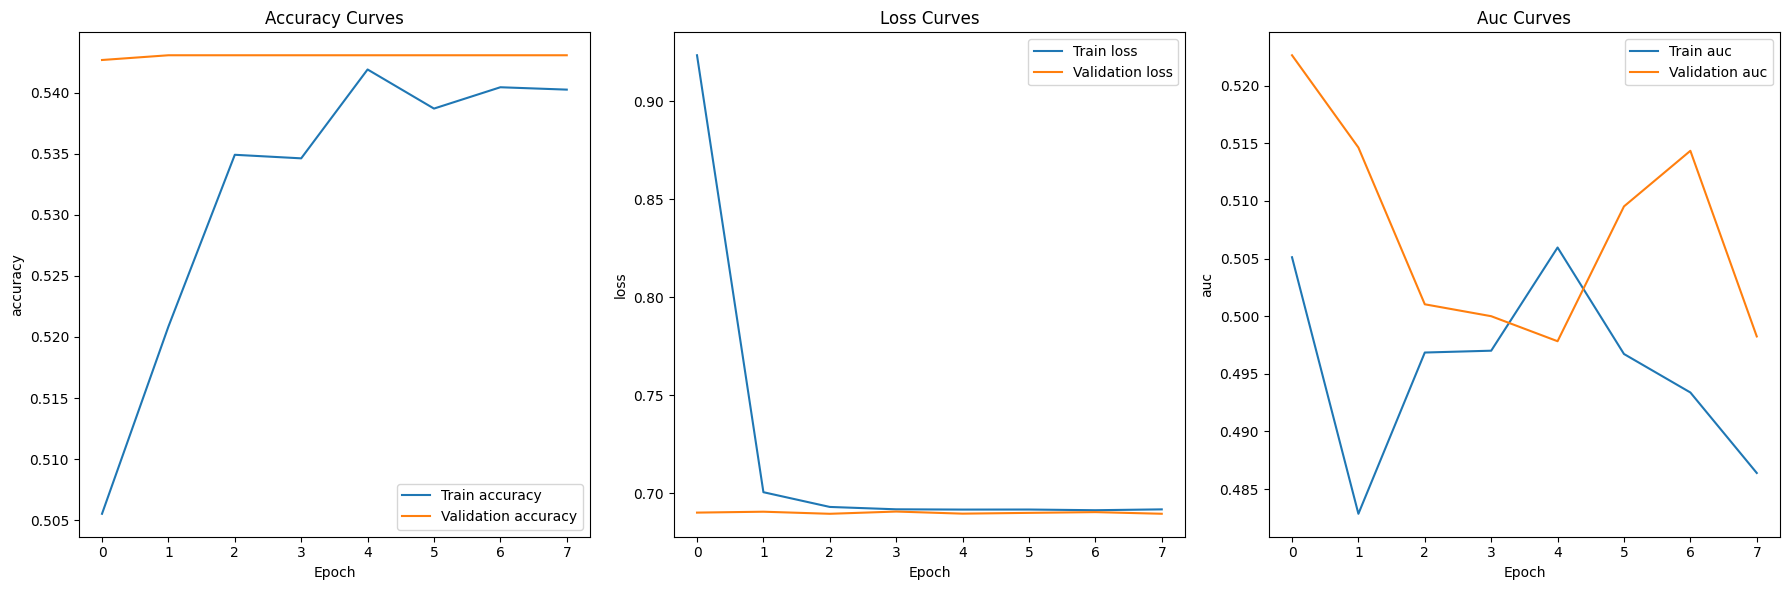

81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step


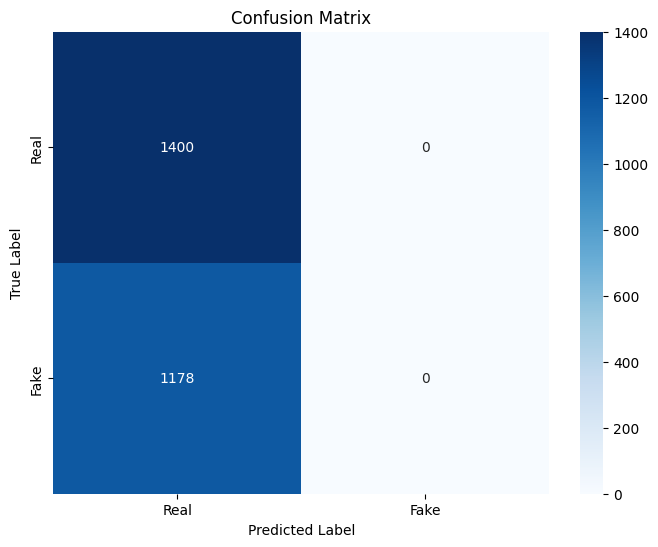

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step

Deepfake Detection Results:
Image: /Users/fenilvadher/Documents/Collage Data/SEM - 6/AI/AI Project/Final Dataset/real/02725.jpg
Prediction: Real
Confidence: 52.48%
Probability: 0.4752

Training complete! Model saved to deepfake_detector.keras


In [23]:
# =============================================
# 8. MAIN EXECUTION
# =============================================
if __name__ == "__main__":
    # Verify TensorFlow
    print(f"TensorFlow version: {tf.__version__}")
    
    # Prepare data
    train_gen, val_gen = prepare_data()
    
    # Build and train model
    model = build_model()
    model.summary()
    
    history = train_model(model, train_gen, val_gen)
    
    # Visualize results
    visualize_results(history, val_gen, model)
    
    # Initialize detector
    detector = DeepfakeDetector(Config.model_save_path)
    
    # Example prediction (using a file from the original dataset)
    sample_image = os.path.join(Config.data_dir, 'real', os.listdir(os.path.join(Config.data_dir, 'real'))[0])
    result = detector.predict(sample_image)
    
    print("\nDeepfake Detection Results:")
    print(f"Image: {sample_image}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probability: {result['probability']:.4f}")
    
    # Clean up (optional - comment out if you want to keep temp data)
    shutil.rmtree(Config.temp_dir)
    
    print(f"\nTraining complete! Model saved to {Config.model_save_path}")